# Analytical solution to a 1D FLD problem

Credit for providing the solution and the setup goes to Alex Ziampras. Thanks, Alex!

$$\Sigma c_v \frac{\partial T}{\partial t} = -\nabla\cdot\vec{F}, \qquad \vec{F} = -\lambda\frac{16\sigma T^3}{\kappa\rho} \nabla T$$

$$\nabla\cdot\vec{F} = 0 \Rightarrow \nabla \cdot \left[\frac{T^3}{\rho} \nabla T\right] = 0$$

cylindrical: $$\frac{1}{R}\frac{\partial}{\partial R}\left(\frac{T^3 H}{\Sigma} R \frac{\partial T}{\partial R}\right) = 0\qquad(\rho\propto \Sigma/H)$$

$H\propto \sqrt{R^3 T}$, $\Sigma\propto R^{-1/2}$:
$$\frac{\partial}{\partial R}\left(\frac{T^3 R^{3/2} T^{1/2}}{R^{-1/2}} R \frac{\partial T}{\partial R}\right) = 0$$

$$\frac{\partial}{\partial R}\left(T^{7/2} R^3 \frac{\partial T}{\partial R}\right) = 0$$

$$T^{7/2} R^3 \frac{\partial T}{\partial R} = c_1$$

$$T^{7/2} dT = c_1 \frac{dR}{R^3}$$

$$T^{9/2} = c_1 \frac{1}{R^2} + c_2$$

$$T = \left(c_1 R^{-2} + c_2\right)^{2/9}$$

$T(R_\mathrm{min}) = T_\mathrm{min}$, $T(R_\mathrm{max}) = T_\mathrm{max}$

define $T_1 = T_\mathrm{min}^{9/2}$, $T_2 = T_\mathrm{max}^{9/2}$, $R_1 = R_\mathrm{min}^{-2}$, $R_2 = R_\mathrm{max}^{-2}$

then $$c_1 = \frac{T_2 - T_1}{R_2-R_1}\qquad c_2 = \frac{R_2 T_1 - R_1 T_2}{R_2-R_1}$$

In [1]:
import numpy as np

def calc_theo(R):
    
    mu = 2.353
    K = 106701.29 # code unit for temperature
    T0 = mu * 0.05**2 * K


    f1, f2 = -3.5, 5 # old module
    f1, f2 = -2, 9/2 # new module

    Rmin = R[0]
    Rmax = R[-1]

    R1 = Rmin ** f1
    R2 = Rmax ** f1
    T1 = (T0 / Rmin)**f2
    T2 = (T0 / Rmax)**f2
    c1 = (T2-T1) / (R2-R1)
    c2 = (R2*T1 - R1*T2) / (R2-R1)
    T = (c1 * R ** f1 + c2) ** (1/f2)

    from types import SimpleNamespace

    theo = SimpleNamespace()
    theo.R = R
    theo.T = T
    theo.T0 = T0
    return theo

## Plot data

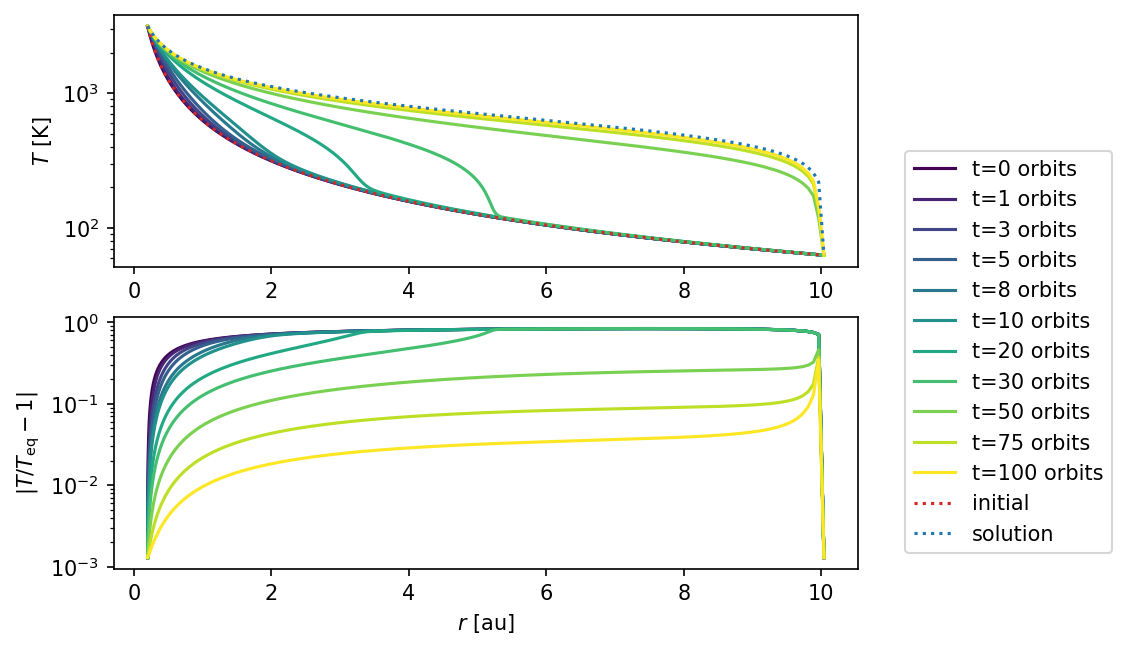

In [2]:


import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, dpi=150)

from disgrid import Data
d = Data("output/out")

name = "energy"
dataunit = "J/cm2"

Nfirst = d.avail()["Nfirst"]
Nlast = d.avail()["Nlast"]

Tunit = 1.0670018430261180e+05

field = d.get(dim="2d", var=name, N=0)
grid = field.grid
r = grid.get_centers("r").to_value("au")

theo = calc_theo(r)

Nr = len(grid.get_centers("r"))
Nphi = len(grid.get_centers("phi"))
T = np.fromfile(d.path+"/snapshots/0/Temperature.dat", dtype=np.float64).reshape(Nr, Nphi)*Tunit
profile0 = np.average(T, axis=1)

cmap = plt.cm.get_cmap("viridis")



inds = np.linspace(Nfirst, Nlast, 10, dtype=int)
inds = [0, 1, 3, 5, 8, 10, 20, 30, 50, 75, 100]
for k, n in enumerate(inds):
    color = cmap(k/(len(inds)-1))
    
    field = d.get(dim="2d", var=name, N=n)
    T = np.fromfile(d.path+f"/snapshots/{n}/Temperature.dat", dtype=np.float64).reshape(Nr, Nphi)*Tunit

    r = grid.get_centers("r").to_value("au")
    Z = T

    
    y = np.average(Z, axis=1)
    
    t = field.time.to_value("yr")/1**1.5
    line, = axes[0].plot(r, y, label=f"t={t:.0f} orbits", color=color)
    axes[1].plot(r, np.abs((y/theo.T-1)), label=f"t={t:.3f}yr", color=color)


### Plot theoretical data

axes[0].plot(theo.R, theo.T0 / theo.R, ls=":", label='initial', color="tab:red")
axes[0].plot(theo.R, theo.T, ls=":", label='solution')


axes[0].legend(bbox_to_anchor=(1.05,0.5))

axes[0].set_ylabel('$T$ [K]')
axes[0].set_yscale('log')
axes[1].set_ylabel('$|T/T_\mathrm{eq} - 1|$')
axes[1].set_yscale('log')
axes[1].set_xlabel('$r$ [au]')
plt.show()

Could also plot radiative flux  $F_\text{rad} \propto \frac{T^3}{\rho} \nabla T$, this should be constant